# Analyze results from the groundwater modeling challenge

In this notebook, the results from the groundwater modeling challenge are analyzed.

*Author: R.A. Collenteur, March 2024*

## 0. Load Python packages

In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import pastas as ps
import matplotlib.colors as mcolors

from matplotlib.gridspec import GridSpec
ps.set_log_level("ERROR")
ps.show_versions()

plt.style.use("seaborn-v0_8-colorblind")
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Python version: 3.10.13
NumPy version: 1.23.5
Pandas version: 2.1.4
SciPy version: 1.12.0
Matplotlib version: 3.8.0
Numba version: 0.59.0
LMfit version: Not Installed
Latexify version: Not Installed
Pastas version: 1.1.0


## 1. Load data

In [2]:
name_sort = {'Lumped':0,'ML':1,'DL':2}

teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.drop("runwaygrey")  # Results do not seem correct, so not considered further
teams = teams.drop("regression")  # Opted out of challenge
order = [str(name) for name in teams.loc[:, ("General Info", "Type")].map(name_sort).sort_values().index.astype(str)]
order

['da_collective',
 'gardenia',
 'HydroSight',
 'Janis',
 'Mirkwood',
 'Selina_Yang',
 'MxNl',
 'GEUS',
 'LUHG',
 'M2C_BRGM',
 'TUD',
 'RouhaniEtAl',
 'TUV',
 'haidro',
 'uw']

## 2. Set start and end of validation period

In [3]:
tmin = {
    "Netherlands": "2016-09-23",
    "USA": "2017-01-18",
    "Germany": "2017-01-01",
    "Sweden_1": "2016-01-05",
    "Sweden_2": "2016-01-05",
}

tmax = {
    "Netherlands": "2020-11-27",
    "USA": "2021-12-31",
    "Germany": "2021-12-31",
    "Sweden_1": "2020-12-29",
    "Sweden_2": "2020-12-29",
}

## 3. Load the simulated and measured head data

In [4]:
sims = pd.read_csv("../data/all_results.csv", index_col=0, parse_dates=True, header=[0, 1, 2])

wells = sims.columns.get_level_values(1).unique()#.drop("Sweden_1")
names = ['USA', 'Netherlands', 'Germany', 'Sweden']

heads = []

for well in wells:
    head = pd.read_csv("../data/{}/heads_full.csv".format(well), 
                       index_col=0, parse_dates=True).squeeze().dropna()
    head.index = head.index.round("D")    
    head.name = well
    heads.append(head.loc[~head.index.duplicated()])

heads = pd.concat(heads, axis=1)
heads = heads.loc[~heads.index.duplicated()].sort_index()

## 4. Compute goodness-of-fit metrics

In [5]:
stats = ["mae", "rmse", "nse"]
team_names = sims.columns.get_level_values(0).unique()
periods = ["calibration", "validation"]

mi = pd.MultiIndex.from_product([periods, stats, wells])
metrics = pd.DataFrame(index=team_names, columns=mi, dtype=float)

for i, well in enumerate(wells):
    head = heads.loc[:, well].dropna()    
    sim = sims.loc[:, (slice(None), well, "Simulated Head")].astype(float)
    
    for name, ts in sim.items():
        for period in periods:
            if period == "calibration":
                tn = "2000-01-01"
                tx = tmin[well]
            else:
                tn = tmin[well]
                tx = tmax[well]
            
            if ts.dropna().empty:
                pass
            else:
                s = ts.loc[ts.index.drop_duplicates()].dropna()
                idx = head.loc[tn:tx].dropna().index.intersection(s.dropna().index)
    
                h = head.loc[idx]
                s = s.loc[idx]
                
                for stat in stats:
                    metrics.loc[name[0], (period, stat, well)] = getattr(ps.stats.metrics, stat)(obs=h, sim=s)
    
                metrics.loc[name[0], (period, "mae_20", well)] = ps.stats.metrics.mae(h[h<h.quantile(0.2)], s)
                metrics.loc[name[0], (period, "mae_80", well)] = ps.stats.metrics.mae(h[h>h.quantile(0.8)], s)
                metrics.loc[name[0], (period, "mae_10", well)] = ps.stats.metrics.mae(h[h<h.quantile(0.1)], s)
                metrics.loc[name[0], (period, "mae_90", well)] = ps.stats.metrics.mae(h[h>h.quantile(0.9)], s)
                metrics.loc[name[0], (period, "mae_05", well)] = ps.stats.metrics.mae(h[h<h.quantile(0.05)], s)
                metrics.loc[name[0], (period, "mae_95", well)] = ps.stats.metrics.mae(h[h>h.quantile(0.95)], s)
                
            # Compute the PICP values
            bounds = sims.loc[tn:tx, pd.IndexSlice[name[0], well, ["95% Lower Bound", "95% Upper Bound"]]]
            if not bounds.dropna().empty:
                nobs_between = h.between(bounds.loc[h.index].iloc[:,0], bounds.loc[h.index].iloc[:,1]).sum()
                nobs = h.index.size
                metrics.loc[name[0], (period, "PICP", well)] = nobs_between / nobs
            else: 
                metrics.loc[name[0], (period, "PICP", well)] = np.nan

metrics.head().round(2)

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_59416/2881906748.py:45: RuntimeWarning: invalid value encountered in scalar divide
  metrics.loc[name[0], (period, "PICP", well)] = nobs_between / nobs
/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_59416/2881906748.py:45: RuntimeWarning: invalid value encountered in scalar divide
  metrics.loc[name[0], (period, "PICP", well)] = nobs_between / nobs


calibration                                                      \
                      mae                                        rmse           
Team          Netherlands Germany Sweden_1 Sweden_2   USA Netherlands Germany   
da_collective        0.02    0.05     0.10     0.19  0.16        0.03    0.08   
GEUS                 0.02    0.08     0.07     0.23  0.08        0.04    0.11   
Janis                0.00    0.01     0.02     0.07  0.01        0.01    0.02   
LUHG                 0.05    0.13     0.09     0.40  0.27        0.06    0.18   
M2C_BRGM             0.03    0.10     0.07     0.51  0.17        0.04    0.13   

                                       ...                     validation  \
                                       ... mae_05 mae_95  PICP     mae_20   
Team          Sweden_1 Sweden_2   USA  ...    USA    USA   USA        USA   
da_collective     0.13     0.24  0.21  ...   0.08   0.19  0.51       0.46   
GEUS              0.10     0.32  0.13  ...   0.05   0.12  0.99       0.31   
Janis             0.03     0.11  0.02  ...   0.01   0.02  0.99       0.15   
LUHG              0.12     0.59  0.35  ...   0.24   0.50  0.97       0.36   
M2C_BRGM          0.10     0.65  0.22  ...   0.39   0.10  0.67       0.24   

                                                        
              mae_80 mae_10 mae_90 mae_05 mae_95  PICP  
Team             USA    USA    USA    USA    USA   USA  
da_collective   0.20   0.38   0.23   0.18   0.23  0.98  
GEUS            0.20   0.29   0.19   0.21   0.18  0.93  
Janis           0.19   0.17   0.19   0.12   0.17  0.42  
LUHG            0.40   0.42   0.46   0.34   0.46  0.95  
M2C_BRGM        0.10   0.19   0.09   0.16   0.09  0.73  

[5 rows x 100 columns]

## 5. Look at the results of Sweden_1

The models from all teams for this well have very low performance, as shown by NSE values in the validation period that are negative. It is therefore decided to not look further into the results from this well.

In [6]:
metrics.loc[:, ("validation", slice(None), "Sweden_1")].round(2)

validation                                               \
                     mae     rmse      nse   mae_20   mae_80   mae_10   
Team            Sweden_1 Sweden_1 Sweden_1 Sweden_1 Sweden_1 Sweden_1   
da_collective       0.34     0.39    -2.28     0.28     0.38     0.21   
GEUS                0.30     0.34    -1.55     0.22     0.36     0.19   
Janis               0.32     0.37    -1.91     0.22     0.41     0.17   
LUHG                0.32     0.37    -1.98     0.22     0.42     0.18   
M2C_BRGM            0.46     0.57    -5.88     0.23     0.87     0.23   
Mirkwood            0.36     0.43    -2.88     0.26     0.47     0.23   
Selina_Yang          NaN      NaN      NaN      NaN      NaN      NaN   
TUD                  NaN      NaN      NaN      NaN      NaN      NaN   
RouhaniEtAl         0.48     0.59    -6.47     0.28     0.79     0.29   
gardenia            0.34     0.41    -2.56     0.12     0.66     0.15   
HydroSight          0.33     0.37    -1.89     0.21     0.42     0.13   
MxNl                0.28     0.33    -1.33     0.20     0.38     0.18   
TUV                  NaN      NaN      NaN      NaN      NaN      NaN   
haidro              0.31     0.37    -1.88     0.23     0.38     0.22   
uw                   NaN      NaN      NaN      NaN      NaN      NaN   

                                                   
                mae_90   mae_05   mae_95     PICP  
Team          Sweden_1 Sweden_1 Sweden_1 Sweden_1  
da_collective     0.39     0.19     0.43     0.41  
GEUS              0.36     0.05     0.36     0.30  
Janis             0.39     0.06     0.38     0.08  
LUHG              0.44     0.09     0.43     0.25  
M2C_BRGM          1.02     0.27     1.07     0.27  
Mirkwood          0.51     0.04     0.52     0.01  
Selina_Yang        NaN      NaN      NaN      NaN  
TUD                NaN      NaN      NaN      NaN  
RouhaniEtAl       0.94     0.27     1.04     0.00  
gardenia          0.75     0.19     0.82      NaN  
HydroSight        0.43     0.10     0.46     0.30  
MxNl              0.36     0.05     0.38     0.05  
TUV                NaN      NaN      NaN      NaN  
haidro            0.38     0.09     0.37     0.11  
uw                 NaN      NaN      NaN      NaN

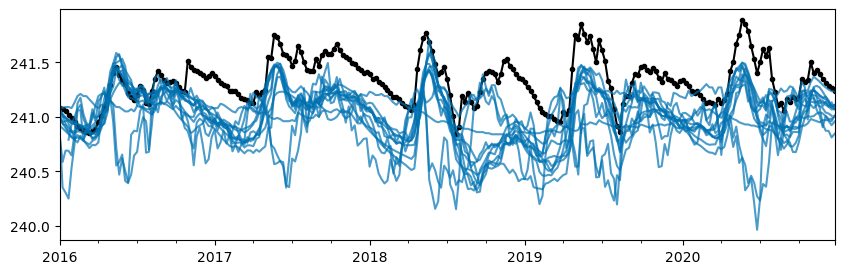

In [7]:
ax = heads.loc[tmin["Sweden_1"]:tmax["Sweden_1"], "Sweden_1"].dropna().plot(marker=".", color="k", figsize=(10,3))
for name, sim in sims.loc[tmin["Sweden_1"]:tmax["Sweden_1"], (slice(None), "Sweden_1", "Simulated Head")].items():
    if not sim.dropna().empty:
        sim.dropna().plot(legend=False, ax=ax, alpha=0.7, color="C0")

## 6. Deselect Sweden_1 from further analysis

In [8]:
wells = sims.columns.get_level_values(1).unique().drop("Sweden_1")
metrics = metrics.loc[:, (slice(None), slice(None), wells)]

## 7. Define plotting function 

In [9]:
# Reverse once here..
order.reverse()

In [10]:
def plot_metrics(metric, label, best="max"):
    """
    Parameters
    ----------
    best: str
        'max' for when the maximum is the best, 'min' for the opposite.

    """
    fig = plt.figure(figsize=(5,5),  layout="tight")
    spec = fig.add_gridspec(ncols=4, nrows=16, left=0.22)

    top = []
    axes =[]
    axb = None
    axt = None

    for i in range(4):
        if axb is not None:
            axb = fig.add_subplot(spec[2:16, i], sharey=axb)
        else:
            axb = fig.add_subplot(spec[2:16, i])

        axes.append(axb)

        if axt is not None:
            axt = fig.add_subplot(spec[0:2, i], sharex=axb)
        else:
            axt = fig.add_subplot(spec[0:2, i], sharex=axb)

        top.append(axt)

    # Get metrics values
    m = metrics.loc[order, (slice(None), metric, wells)]
    m.columns = m.columns.droplevel([1])
    
    if best == "min":
        rank = m.abs().rank()
    elif best == "max":
        rank = m.rank(ascending=False)

    for i, well in enumerate(wells):
        ax = axes[i]
        ax.set_title("")
        ax.grid(zorder=-10)
        
        props = dict(boxes=colors[i], whiskers=colors[i], medians='k', caps=colors[i])
        b = m.loc[:, (slice(None), well)].plot.box(vert=False, ax=top[i], title=None, sharey=True, 
                                               widths=0.8, color=props, patch_artist=True)
        b.patches[0].set_alpha(0.5)
        top[i].set_yticklabels(["Calibration", "Validation"])
        top[i].set_title(None)
        
        m.loc[:, (slice(None), well)].plot(kind="barh", legend=False, zorder=10, width=0.8, 
             color=[mcolors.to_rgba((colors[i], 0.5)), mcolors.to_rgba((colors[i], 1.0))], ax=ax)

        if best == "min":
            x, y = m.loc[order, ("validation", well)].abs().min(), m.loc[order, ("validation", well)].argmin()
        elif best == "max":
            x, y = m.loc[order, ("validation", well)].abs().max(), m.loc[order, ("validation", well)].argmax()
            
        axes[i].scatter(x, y, 
                        marker="*", color="gold", zorder=200, edgecolor="k", s=50)
        top[i].set_title(well.split("_")[0], fontsize=10)
        axes[i].set_xlim(0)

        for row, val in enumerate(rank.loc[order, ("validation", well)].values):
            if np.isnan(val):
                pass
            else:
                axes[i].text(0, row, "{:.0f}".format(val), fontsize=6, zorder=20,
                             bbox={"boxstyle" : "circle", "facecolor":"w", "edgecolor": "k"})
    
    # Annotate model groups
    y = 0.71
    plt.annotate('Lumped', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=0.5', lw=1.0));
    y = 0.56
    plt.annotate('ML', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=0.5', lw=1.0));  
    y = 0.3
    plt.annotate('Deep Learning', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
                ha='left', va='center', rotation=90,
                arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.5', lw=1.0));

    fig.text(0.5, 0.02, label, horizontalalignment="center")
    return fig, axes

### Figure 02: NSE

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_59416/1670265920.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_02.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


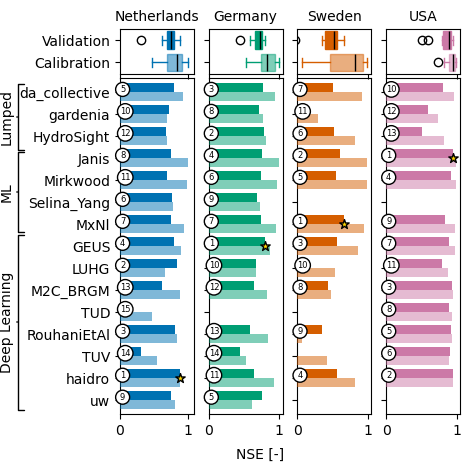

In [11]:
plot_metrics("nse", label="NSE [-]", best="max")
plt.savefig("../figures/figure_02.png", bbox_inches="tight", dpi=300)

### Figure 03: MAE

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_59416/1106482698.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_03.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


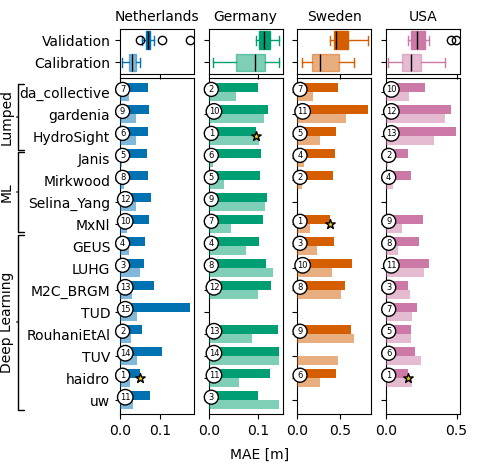

In [12]:
plot_metrics("mae", label="MAE [m]", best="min")
plt.savefig("../figures/figure_03.png", bbox_inches="tight", dpi=300)

### Figure 04: Best model of each category

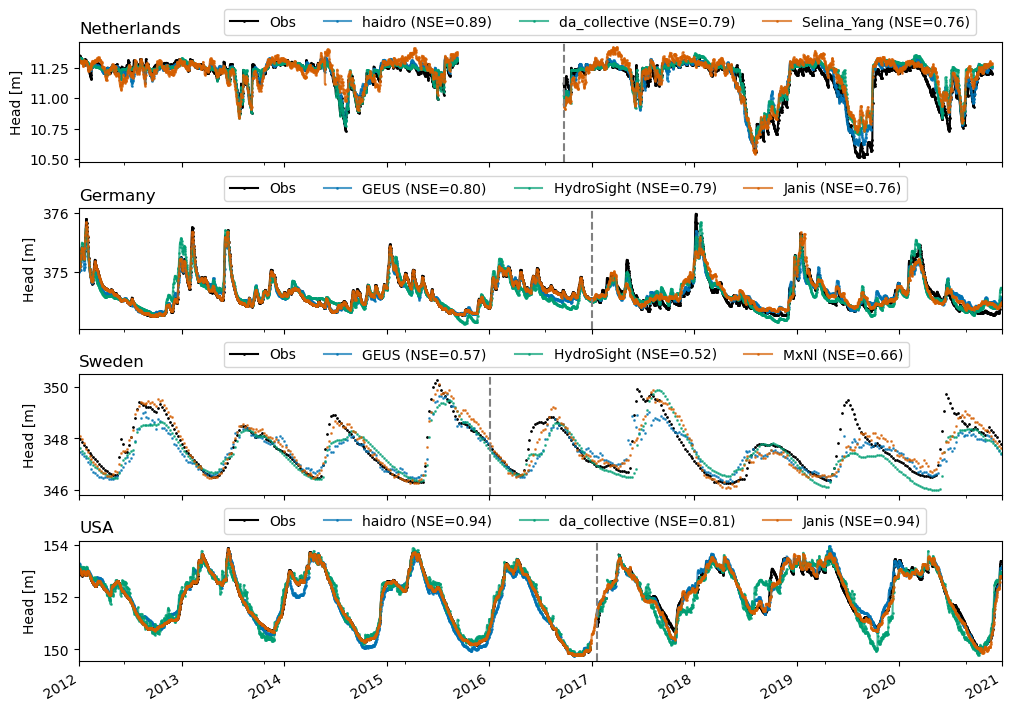

In [13]:
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True, constrained_layout=True)
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)

for i, well in enumerate(wells):
    ax= axes[i]
    
    # Plot the heads
    heads.loc["2012":, well].plot(ax=ax, marker=".", markersize=2, color="k", x_compat=True)
    
    # Select the three best models
    best = metrics.loc[:, ("validation", "nse", well)].groupby(teams.loc[:, ("General Info", "Type")]).nlargest(1)

    for (cat, team), nse in best.items():
        ts = sims.loc["2012":, (team, well, "Simulated Head")]
        ts.plot(ax=ax, alpha=0.7, linestyle="-", marker=".", markersize=2, x_compat=True)

    # Dress up the plot
    ax.set_ylabel("Head [m]")
    ax.set_title(well.split("_")[0], loc="Left")
    ax.set_xlim(["2012", "2021"])
    ax.axvline(tmin[well], linestyle="--", color="gray")
    labels = ["Obs"] + list(best.index.get_level_values(1) + best.apply(" (NSE={:.2f})".format).values)
    ax.legend(labels, ncols=4, bbox_to_anchor=(0.15, 1))

plt.savefig("../figures/figure_04.png", bbox_inches="tight", dpi=300)

### Figure 05: MAE$_{0.8}$ / MAE$_{0.2}$

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_59416/2693215262.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_05.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


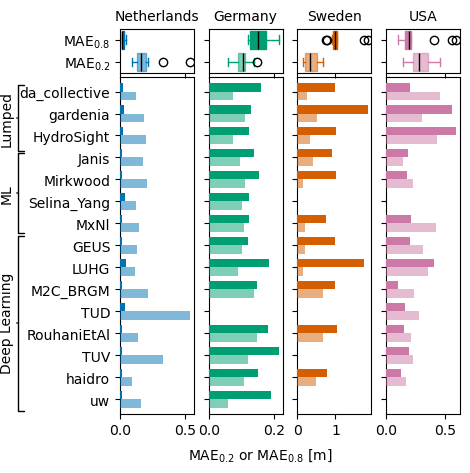

In [14]:
fig = plt.figure(figsize=(5,5),  layout="tight")
spec = fig.add_gridspec(ncols=4, nrows=16, left=0.22)

top = []
axes =[]
axb = None
axt = None

for i in range(4):
    if axb is not None:
        axb = fig.add_subplot(spec[2:16, i], sharey=axb)
    else:
        axb = fig.add_subplot(spec[2:16, i])

    axes.append(axb)

    if axt is not None:
        axt = fig.add_subplot(spec[0:2, i], sharex=axb)
    else:
        axt = fig.add_subplot(spec[0:2, i], sharex=axb)

    top.append(axt)

# Get metrics values
m = metrics.loc[order, ("validation", ["mae_20", "mae_80"], wells)]
m.columns = m.columns.droplevel([0])

for i, well in enumerate(wells):
    ax = axes[i]
    ax.set_title("")
    ax.grid(zorder=-10)
    
    props = dict(boxes=colors[i], whiskers=colors[i], medians='k', caps=colors[i])
    b = m.loc[:, (slice(None), well)].plot.box(vert=False, ax=top[i], title=None, sharey=True, 
                                           widths=0.8, color=props, patch_artist=True)
    b.patches[0].set_alpha(0.5)
    top[i].set_yticklabels(["MAE$_{0.2}$", "MAE$_{0.8}$"])
    top[i].set_title(None)
    
    m.loc[:, (slice(None), well)].plot(kind="barh", legend=False, zorder=10, width=0.8, 
         color=[mcolors.to_rgba((colors[i], 0.5)), mcolors.to_rgba((colors[i], 1.0))], ax=ax)

    top[i].set_title(well.split("_")[0], fontsize=10)
    axes[i].set_xlim(0)

# Annotate model groups
y = 0.71
plt.annotate('Lumped', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=0.5', lw=1.0));
y = 0.56
plt.annotate('ML', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=0.5', lw=1.0));  
y = 0.3
plt.annotate('Deep Learning', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.5', lw=1.0));

fig.text(0.5, 0.02, "MAE$_{0.2}$ or MAE$_{0.8}$ [m]", horizontalalignment="center")
plt.savefig("../figures/figure_05.png", bbox_inches="tight", dpi=300)

### Figure 6: PICP

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_59416/1083126494.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_06.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


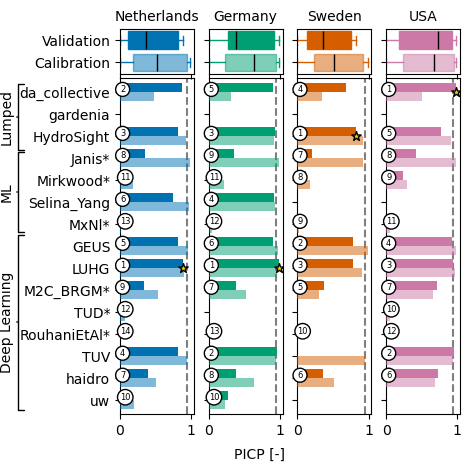

In [15]:
fig, axes = plot_metrics("PICP", label="PICP [-]", best="max")
for ax in axes:
    ax.axvline(0.95, color="gray", linestyle="--")

labels = ['da_collective',
 'gardenia',
 'HydroSight',
 'Janis*',
 'Mirkwood*',
 'Selina_Yang',
 'MxNl*',
 'GEUS',
 'LUHG',
 'M2C_BRGM*',
 'TUD*',
 'RouhaniEtAl*',
 'TUV',
 'haidro',
 'uw']
labels.reverse()
axes[0].set_yticklabels(labels)
plt.savefig("../figures/figure_06.png", bbox_inches="tight", dpi=300)

### Figure 07: Effort and time investment

In [16]:
order.reverse()

In [17]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.loc[:, (["Development time", "Calibration time"], wells)]
teams.head()

orig = teams.loc[order, :].copy()
orig[teams.loc[order, :] < 8] = 2
orig[teams.loc[order, :] < 4] = 1
orig[teams.loc[order, :] < 1] = 0
orig[teams.loc[order, :] > 8] = 3
orig = orig.stack(level=0)

df = pd.DataFrame(data=0, index=pd.MultiIndex.from_product([order, ["Development time", "Calibration time"]]),
                  columns=pd.MultiIndex.from_product([wells, [0,1,2,3]]))

for (team, period, country), group in orig.stack().items():
    df.loc[(team, period), (country, int(group))] = 1
    
df.loc[(slice(None), "Development time"), :] *= 2
df.head()

Team                           Netherlands          Germany          Sweden_2  \
                                         0  1  2  3       0  1  2  3        0   
da_collective Development time           0  0  2  0       0  0  2  0        0   
              Calibration time           0  1  0  0       0  1  0  0        0   
gardenia      Development time           2  0  0  0       2  0  0  0        2   
              Calibration time           1  0  0  0       1  0  0  0        1   
HydroSight    Development time           2  0  0  0       2  0  0  0        2   

Team                                    USA           
                                1  2  3   0  1  2  3  
da_collective Development time  0  2  0   0  0  2  0  
              Calibration time  1  0  0   0  1  0  0  
gardenia      Development time  0  0  0   2  0  0  0  
              Calibration time  0  0  0   1  0  0  0  
HydroSight    Development time  0  0  0   2  0  0  0

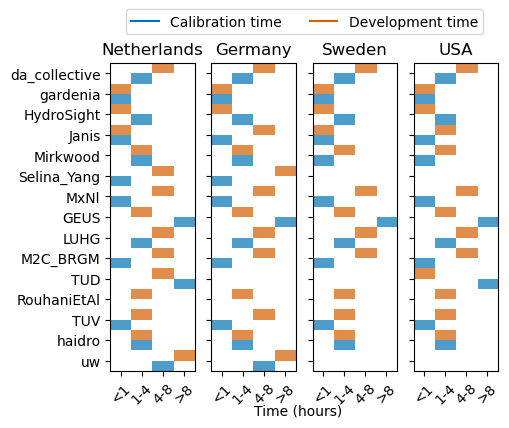

In [18]:
fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(5,4))

cmap = mcolors.ListedColormap(['white', 'C0', "C2"])
bounds=[0,1,2,2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for ax, well in zip(axes, wells):
    ax.imshow(df.loc[order, well].values, aspect="auto", cmap=cmap, norm=norm, alpha=0.7)
    plt.yticks(np.arange(0.5, 30.5, 2), order);
    ax.set_title(well.split("_")[0])
    ax.set_xticks([0,1,2, 3], ["<1", "1-4", "4-8", ">8"], rotation=45)
    
fig.text(0.5, 0, 'Time (hours)', ha='center')

plt.plot(np.nan, color="C0")
plt.plot(np.nan, color="C2")

plt.legend(["Calibration time", "Development time"], ncols=2,
           bbox_to_anchor=(-3.5,1.07), loc=3)

plt.savefig("../figures/figure_07.png", bbox_inches="tight", dpi=300)

### Figure: PICP example

## Compute some numbers for the report

### Report average times

In [19]:
teams = pd.read_excel("../submissions/teams_overview.xlsx", header=[0,1], index_col=0)
teams = teams.loc[:, (["Development time", "Calibration time"], wells)]
(teams.sum(axis=1)/8).describe()

count    17.000000
mean      3.892590
std       5.042856
min       0.193056
25%       1.250000
50%       2.000000
75%       3.000000
max      19.250000
dtype: float64

### Average NSEs over all wells in validation period

In [20]:
metrics.loc[:, ("validation", "nse", slice(None))].mean().mean()

0.6411434979671584

### Excluding Sweden

In [21]:
metrics.loc[:, ("validation", "nse", ["Netherlands", "Germany", "USA"])].mean().mean()

0.719732403216343

## Average NSEs over all wells in calibration period

In [22]:
metrics.loc[:, ("calibration", "nse", slice(None))].mean().mean()

0.80477095476509

### Number of PICP less than 0.5

In [23]:
(metrics.loc[:, ("validation", "PICP", slice(None))].fillna(1) < 0.5).sum()

                  Team       
validation  PICP  Netherlands    8
                  Germany        7
                  Sweden_2       6
                  USA            5
dtype: int64

## Make two figures for the supplementary materials, showing other thresholds for the MAE.

In [24]:
# Reverse once here..
order.reverse()

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_59416/4168183252.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_A1.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


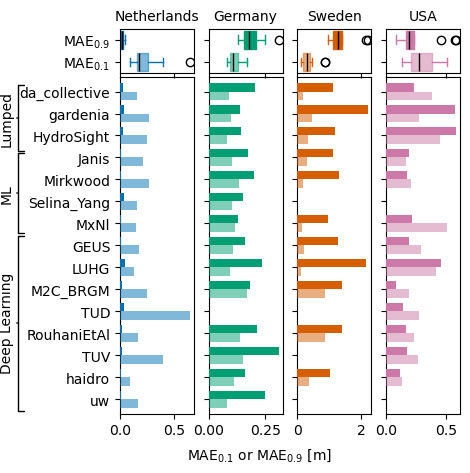

In [25]:
fig = plt.figure(figsize=(5,5),  layout="tight")
spec = fig.add_gridspec(ncols=4, nrows=16, left=0.22)

top = []
axes =[]
axb = None
axt = None

for i in range(4):
    if axb is not None:
        axb = fig.add_subplot(spec[2:16, i], sharey=axb)
    else:
        axb = fig.add_subplot(spec[2:16, i])

    axes.append(axb)

    if axt is not None:
        axt = fig.add_subplot(spec[0:2, i], sharex=axb)
    else:
        axt = fig.add_subplot(spec[0:2, i], sharex=axb)

    top.append(axt)

# Get metrics values
m = metrics.loc[order, ("validation", ["mae_10", "mae_90"], wells)]
m.columns = m.columns.droplevel([0])

for i, well in enumerate(wells):
    ax = axes[i]
    ax.set_title("")
    ax.grid(zorder=-10)
    
    props = dict(boxes=colors[i], whiskers=colors[i], medians='k', caps=colors[i])
    b = m.loc[:, (slice(None), well)].plot.box(vert=False, ax=top[i], title=None, sharey=True, 
                                           widths=0.8, color=props, patch_artist=True)
    b.patches[0].set_alpha(0.5)
    top[i].set_yticklabels(["MAE$_{0.1}$", "MAE$_{0.9}$"])
    top[i].set_title(None)
    
    m.loc[:, (slice(None), well)].plot(kind="barh", legend=False, zorder=10, width=0.8, 
         color=[mcolors.to_rgba((colors[i], 0.5)), mcolors.to_rgba((colors[i], 1.0))], ax=ax)

    top[i].set_title(well.split("_")[0], fontsize=10)
    axes[i].set_xlim(0)

# Annotate model groups
y = 0.71
plt.annotate('Lumped', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=0.5', lw=1.0));
y = 0.56
plt.annotate('ML', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=0.5', lw=1.0));  
y = 0.3
plt.annotate('Deep Learning', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.5', lw=1.0));

fig.text(0.5, 0.02, "MAE$_{0.1}$ or MAE$_{0.9}$ [m]", horizontalalignment="center")
plt.savefig("../figures/figure_A1.png", bbox_inches="tight", dpi=300)

/var/folders/sl/g_rst1mn12xfxjst45qvly880000gp/T/ipykernel_59416/476287149.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("../figures/figure_A2.png", bbox_inches="tight", dpi=300)
/Users/clientadmin/miniconda3/envs/gmc/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


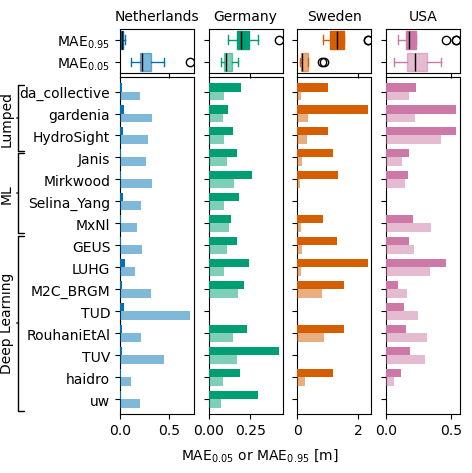

In [26]:
fig = plt.figure(figsize=(5,5),  layout="tight")
spec = fig.add_gridspec(ncols=4, nrows=16, left=0.22)

top = []
axes =[]
axb = None
axt = None

for i in range(4):
    if axb is not None:
        axb = fig.add_subplot(spec[2:16, i], sharey=axb)
    else:
        axb = fig.add_subplot(spec[2:16, i])

    axes.append(axb)

    if axt is not None:
        axt = fig.add_subplot(spec[0:2, i], sharex=axb)
    else:
        axt = fig.add_subplot(spec[0:2, i], sharex=axb)

    top.append(axt)

# Get metrics values
m = metrics.loc[order, ("validation", ["mae_05", "mae_95"], wells)]
m.columns = m.columns.droplevel([0])

for i, well in enumerate(wells):
    ax = axes[i]
    ax.set_title("")
    ax.grid(zorder=-10)
    
    props = dict(boxes=colors[i], whiskers=colors[i], medians='k', caps=colors[i])
    b = m.loc[:, (slice(None), well)].plot.box(vert=False, ax=top[i], title=None, sharey=True, 
                                           widths=0.8, color=props, patch_artist=True)
    b.patches[0].set_alpha(0.5)
    top[i].set_yticklabels(["MAE$_{0.05}$", "MAE$_{0.95}$"])
    top[i].set_title(None)
    
    m.loc[:, (slice(None), well)].plot(kind="barh", legend=False, zorder=10, width=0.8, 
         color=[mcolors.to_rgba((colors[i], 0.5)), mcolors.to_rgba((colors[i], 1.0))], ax=ax)

    top[i].set_title(well.split("_")[0], fontsize=10)
    axes[i].set_xlim(0)

# Annotate model groups
y = 0.71
plt.annotate('Lumped', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=2.4, lengthB=0.5', lw=1.0));
y = 0.56
plt.annotate('ML', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=2.9, lengthB=0.5', lw=1.0));  
y = 0.3
plt.annotate('Deep Learning', xy=(0.035, y), xytext=(0.0, y), xycoords='figure fraction', 
            ha='left', va='center', rotation=90,
            arrowprops=dict(arrowstyle='-[, widthB=6.3, lengthB=0.5', lw=1.0));

fig.text(0.5, 0.02, "MAE$_{0.05}$ or MAE$_{0.95}$ [m]", horizontalalignment="center")
plt.savefig("../figures/figure_A2.png", bbox_inches="tight", dpi=300)